### INSTRUCTIONS

For this assignment, you must use the AWS VM that has been assigned to you.


You can refer to this documentation for additional details:
 - https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16
 - https://www.tensorflow.org/guide/keras/transfer_learning

Then read through the entire framework below once. Note the parts you need to code up.

NOTE: YOU WILL ONLY EDIT ONE CELL (TASKS 1 - 7) FOR THIS ASSIGNMENT AS PER THE INSTRUCTIONS IN THAT CELL

In [1]:
##### DO NOT EDIT THIS CELL!!!
##### DO NOT IMPORT ANY ADDITIONAL PACKAGES

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import cv2

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##### DO NOT EDIT THIS CELL!!!

### read calteach-101 data 

# set up directory paths 
# data_dir = "..\\..\\datasets\\"
data_dir = "C:\\Users\Administrator\\datasets\\"
input_directory = data_dir+'caltech-101'
images_directory = input_directory+'/'+'images'
gt_summary = input_directory+'/'+'gt_summary.csv'

# read gt_summary for ground truth
df = pd.read_csv(gt_summary)

# pick classes for analysis
classes = ['airplanes', 'Faces', 'Motorbikes']
df = df[df['class'].isin(classes)].reset_index(drop=True)

# get image paths
df['imgpath'] = images_directory+'/'+df['filename']
imgpaths = np.array(df['imgpath'])

# get BBs (scaled 0-1)
df['xmin'] = df['xmin']/df['width']
df['ymin'] = df['ymin']/df['height']
df['xmax'] = df['xmax']/df['width']
df['ymax'] = df['ymax']/df['height']
bboxes = np.array(df[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist(), dtype="float32")

# get class labels and one-hot-encode them
labels = np.array(df['class'])
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# print(lb.classes_)
# print (lb.transform(lb.classes_))

# get data (images) resized and scaled 0-1
# img_size is based on transfer learning model we plan on using;
# for VGG16, it's 224
data = []
for imgpath in imgpaths:
    image = load_img(imgpath, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)
data = np.array(data, dtype="float32")/255.0

# split data into train, test, and validate
train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.10

# first split into train and test
(train_images, test_images, 
 train_labels, test_labels, 
 train_BBs, test_BBs, 
 train_paths, test_paths) = train_test_split(
    data, 
    labels, 
    bboxes, 
    imgpaths, 
    test_size=(1-train_ratio), random_state=42)

# then furhter split test into val and test
(val_images, test_images, 
 val_labels, test_labels, 
 val_BBs, test_BBs, 
 val_paths, test_paths) = train_test_split(
    test_images, 
    test_labels, 
    test_BBs, 
    test_paths, 
    test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

print (train_images.shape, val_images.shape, test_images.shape)

(1524, 224, 224, 3) (305, 224, 224, 3) (204, 224, 224, 3)


In [10]:
##### THIS IS THE ONLY CELL YOU WILL EDIT PER THE ISNTRUCTIONS BELOW

# load vgg16 backbone
#  - set weights to "imagenet"
#  - set input shape to (224, 224, 3)
#  - do not include the vgg16 top
### (1) YOUR CODE HERE
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



vgg16_backbone = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None
)


# freeze the backbone
### (2) YOUR CODE HERE
for layer in vgg16_backbone.layers:
    layer.trainable = False


# flatten output from backbone model
### (3) YOUR CODE HERE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

output = Flatten()(vgg16_backbone.output)
model = Model(inputs=vgg16_backbone.input, outputs=output)


# classification head architecture:
#  - Dense layer with 512 units and relu activation
#  - Dropout layer with rate 0.5
#  - Dense layer with 512 units and relu activation
#  - Dropout layer with rate 0.5
#  - Dense layer with 3 units, softmax activation; name this output layer "clshead"
### (4) YOUR CODE HERE
x = Dense(512, activation='relu')(output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
classification_output = Dense(3, activation='softmax', name='clshead')(x)



# regression head architecture:
#  - Dense layer with 128 units and relu activation
#  - Dense layer with 64 units and relu activation
#  - Dense layer with 32 units and relu activation
#  - Dense layer with 4 units, sigmoid activation; name this output layer "reghead"
#    (do you know why we're using output activation of sigmoid here for regression?)
### (5) YOUR CODE HERE
y = Dense(128, activation='relu')(output)
y = Dense(64, activation='relu')(y)
y = Dense(32, activation='relu')(y)
regression_output = Dense(4, activation='sigmoid', name='reghead')(y)



# create model:
#  - set inputs to 'backbone.input'
#  - set outputs to regression output followed by classification output
#     (NOTE: order is important since that is the order in which values will get predicted!)
### (6) YOUR CODE HERE
model = Model(inputs=vgg16_backbone.input, outputs=[regression_output, classification_output])


# compile model
#  - use Adam with learning rate of 1e-4
#  - set clshead metric to 'accuracy' , and reghead metric to 'mse'
#  - set clshead loss to 'categorical_crossentropy' , and reghead loss to 'mean_squared_error'
#  - set clshead weight to 1.0, and reghead weight to 1.0
### (7) YOUR CODE HERE
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'clshead': 'categorical_crossentropy',
        'reghead': 'mean_squared_error'
    },
    metrics={
        'clshead': 'accuracy',
        'reghead': 'mse'
    },
    loss_weights={
        'clshead': 1.0,
        'reghead': 1.0
    }
)


# print model summary
# you should get Total params: 31,046,311
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [11]:
%%time

##### DO NOT EDIT THIS CELL!!!

# train model
history = model.fit(
    train_images, {'clshead': train_labels, 'reghead': train_BBs},
    validation_data=(val_images, {'clshead': val_labels, 'reghead': val_BBs}),
    batch_size=32,
    epochs=15,
    verbose=1)

Epoch 1/15
48/48 [==============================] - 167s 3s/step - loss: 0.1943 - reghead_loss: 0.0111 - clshead_loss: 0.1832 - reghead_mse: 0.0111 - clshead_accuracy: 0.9239 - val_loss: 0.0034 - val_reghead_loss: 0.0019 - val_clshead_loss: 0.0015 - val_reghead_mse: 0.0019 - val_clshead_accuracy: 1.0000
Epoch 2/15
48/48 [==============================] - 164s 3s/step - loss: 0.0128 - reghead_loss: 0.0012 - clshead_loss: 0.0116 - reghead_mse: 0.0012 - clshead_accuracy: 0.9974 - val_loss: 0.0018 - val_reghead_loss: 0.0012 - val_clshead_loss: 6.1651e-04 - val_reghead_mse: 0.0012 - val_clshead_accuracy: 1.0000
Epoch 3/15
48/48 [==============================] - 164s 3s/step - loss: 0.0069 - reghead_loss: 8.4686e-04 - clshead_loss: 0.0061 - reghead_mse: 8.4686e-04 - clshead_accuracy: 0.9993 - val_loss: 0.0014 - val_reghead_loss: 0.0010 - val_clshead_loss: 3.2820e-04 - val_reghead_mse: 0.0010 - val_clshead_accuracy: 1.0000
Epoch 4/15
48/48 [==============================] - 162s 3s/step - lo

dict_keys(['loss', 'reghead_loss', 'clshead_loss', 'reghead_mse', 'clshead_accuracy', 'val_loss', 'val_reghead_loss', 'val_clshead_loss', 'val_reghead_mse', 'val_clshead_accuracy'])


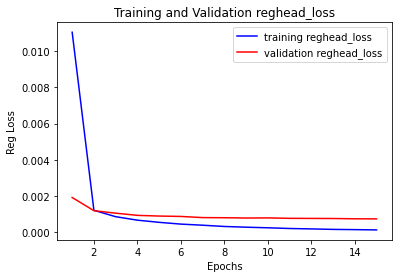

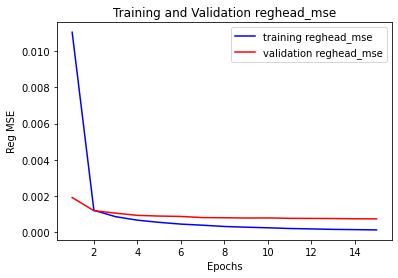

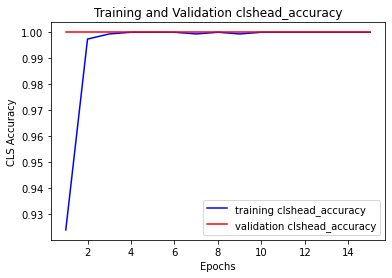

In [12]:
##### DO NOT EDIT THIS CELL!!!

# model.fit() returns a History object that contains a dictionary with everything that happened during training
# we can use it to plot training/validation loss and training/validation accuracy
history_dict = history.history
print (history_dict.keys())

# plot total loss
loss = history_dict['reghead_loss']
val_loss = history_dict['val_reghead_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='training reghead_loss')
plt.plot(epochs, val_loss, 'r', label='validation reghead_loss')
plt.title('Training and Validation reghead_loss')
plt.xlabel('Epochs')
plt.ylabel('Reg Loss')
plt.legend()
plt.show()

# plot mse for reghead
mse = history_dict['reghead_mse']
val_mse = history_dict['val_reghead_mse']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'b', label='training reghead_mse')
plt.plot(epochs, val_mse, 'r', label='validation reghead_mse')
plt.title('Training and Validation reghead_mse')
plt.xlabel('Epochs')
plt.ylabel('Reg MSE')
plt.legend()
plt.show()

# plot accuracy for clshead
acc = history_dict['clshead_accuracy']
val_acc = history_dict['val_clshead_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='training clshead_accuracy')
plt.plot(epochs, val_acc, 'r', label='validation clshead_accuracy')
plt.title('Training and Validation clshead_accuracy')
plt.xlabel('Epochs')
plt.ylabel('CLS Accuracy')
plt.legend()
plt.show()

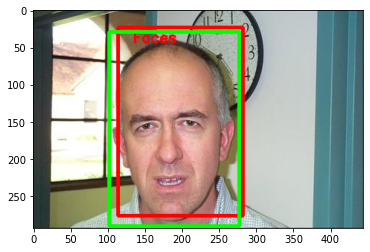

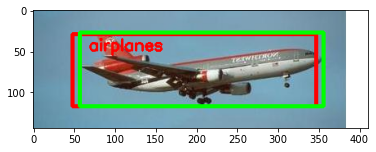

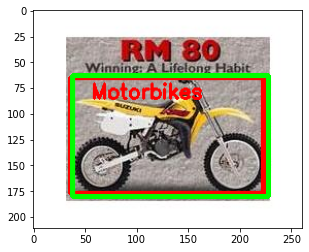

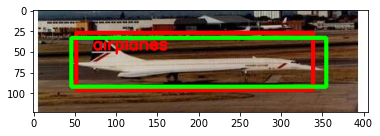

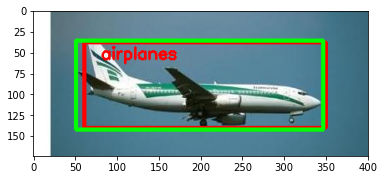

In [13]:
##### DO NOT EDIT THIS CELL!!!

def predict_and_display(image_index=0):

    testimgpath = test_paths[image_index]
    img = cv2.imread(testimgpath)
    (height, width) = img.shape[:2]

    # read and preprocess test image
    image = load_img(testimgpath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # get gt label 
    gt_label = test_labels[image_index]

    # get gt BB
    (gtxmin, gtymin, gtxmax, gtymax) = test_BBs[image_index]

    # scale gt bb to image scale
    gtxmin = int(gtxmin*width)
    gtymin = int(gtymin*height)
    gtxmax = int(gtxmax*width)
    gtymax = int(gtymax*height)

    # predict using model
    # NOTE: these will come out in the same order as you specified in Model outputs
    (pred_BB, pred_label) = model.predict(image)

    # get predicted label
    pred_label = lb.classes_[np.argmax(pred_label, axis=1)][0]

    # get predicted BB
    (pxmin, pymin, pxmax, pymax) = pred_BB[0]

    # scale pred bb to image scale
    pxmin = int(pxmin*width)
    pymin = int(pymin*height)
    pxmax = int(pxmax*width)
    pymax = int(pymax*height)

    # display image along with gt and pred BBs
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, pred_label, (pxmin+20, pymin+20), cv2.FONT_HERSHEY_SIMPLEX,0.65, (255, 0, 0), 2)
    cv2.rectangle(img, (pxmin, pymin), (pxmax, pymax), (255,0,0), 3)
    cv2.rectangle(img, (gtxmin, gtymin), (gtxmax, gtymax), (0,255,0), 3)
    plt.imshow(img)
    plt.show()

# predict on a few test images
np.random.seed(42)
for idx in np.random.randint(0, test_images.shape[0], 5):
    predict_and_display(idx)